In [ ]:
!python --version

In [ ]:
!nvidia-smi

In [3]:
# !pip install supervision
# !pip install timm
# !python -m pip install --upgrade pip
# !pip install supervision
# !pip install timm
# !pip install cython
# !pip install pycocotools
# !pip install scipy

# !pip install -q transformers
# !pip install -q pytorch-lightning

### 1. Create COCO data loader


In [1]:
import torchvision
import os

ANNOTATION_FILE_NAME = "annotations.json"

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [2]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

dataset = '../Manga109/dataset_split'
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "val")
TEST_DIRECTORY = os.path.join(dataset, "test")

train_dataset = CocoDetection(img_folder=TRAIN_DIRECTORY, processor=processor)
val_dataset = CocoDetection(img_folder=VAL_DIRECTORY, processor=processor, train=False)

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [3]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 7085
Number of validation examples: 1383


Image n°11105


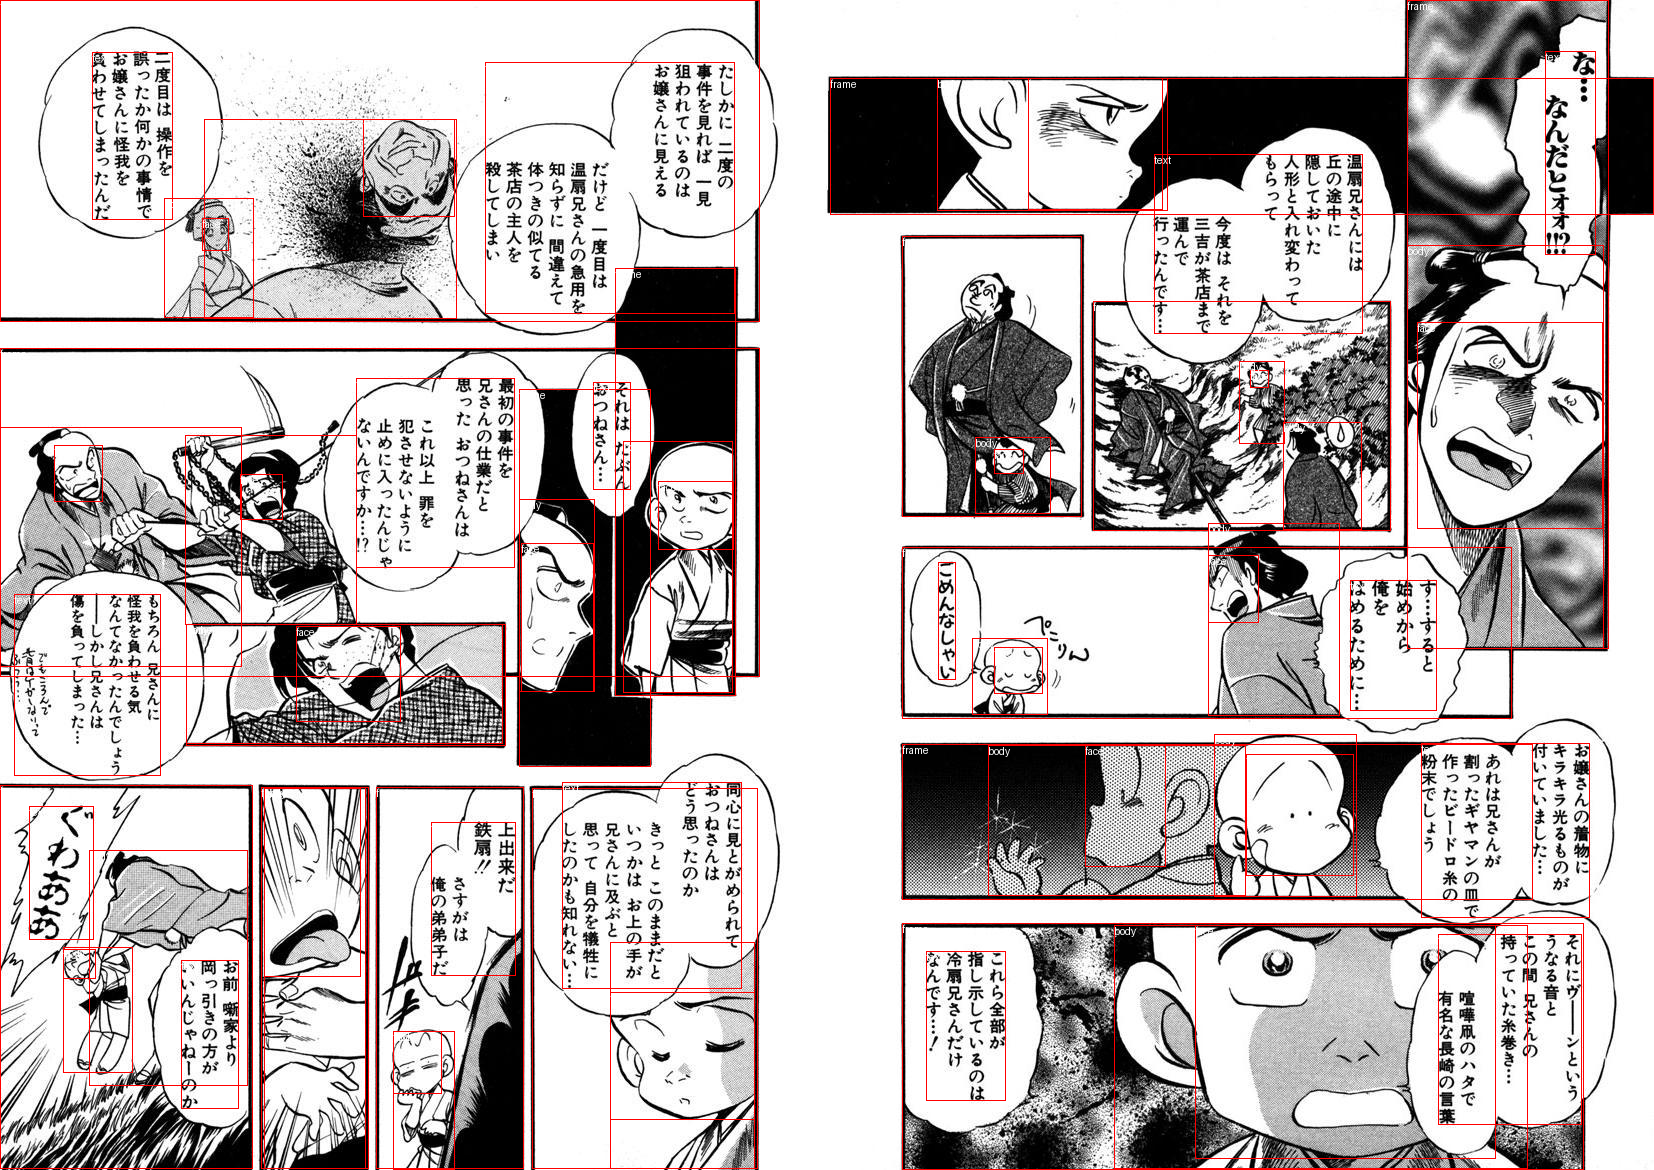

In [13]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()

# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
# image_id = image_ids[17]
# print(f'image_id: {image_id}')

print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
# print(f'image: {image}')

image = Image.open(os.path.join(TRAIN_DIRECTORY, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
# print(f'annotations: {annotations}')
# print(f'annotations: {len(annotations)}')

draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
    draw.text((x, y), id2label[class_idx], fill='white')

image